# EXPERIMENTAL PROJECTS: muffin vs chihuaha
Use Keras to train a neural network for the binary classification of muffins and Chihuahuas based on images from this dataset.

Images must be transformed from JPG to RGB (or grayscale) pixel values and scaled down. The student is asked to:

* experiment with different network architectures (at least 3) and training hyperparameters,
* use 5-fold cross validation to compute your risk estimates,
* thoroughly discuss the obtained results, documenting the influence of the choice of the network architecture and the tuning of the hyperparameters on the final cross-validated risk estimate.

While the training loss can be chosen freely, the reported cross-validated estimates must be computed according to the zero-one loss.

## Download data


Download data from [link images](https://https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

For simplicity, I've downloaded the files and stored them on Google Drive. I've then mounted gDrive. For privacy reasons, I've omitted a specific part of the process. However, if you need to access the data, you can download data from this link.

In [ ]:
#!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification
#!unzip -q muffin-vs-chihuahua-image-classification.zip
!pip -q install plot_keras_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


##Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import cv2
from tqdm.notebook import tqdm_notebook

from plotnine import *

from sklearn.datasets import load_files
#from tf.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn import preprocessing


from sklearn.utils import shuffle
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,AveragePooling2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from plot_keras_history import plot_history


In [ ]:
train_dir = "train/"
test_dir = "test/"

BATCH_SIZE = 32
IMG_SIZE= 128

## Data Description

The dataset consists of 6000 images divided into two main directories: "train" and "test". The distribution of images within these directories is as follows:

In [ ]:
root_path=train_dir
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
counts_train = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts_train[i] = len(os.listdir(directory))
print(counts_train)

[2559, 2174]


In [ ]:
root_path=test_dir
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))
print(counts)

[640, 544]


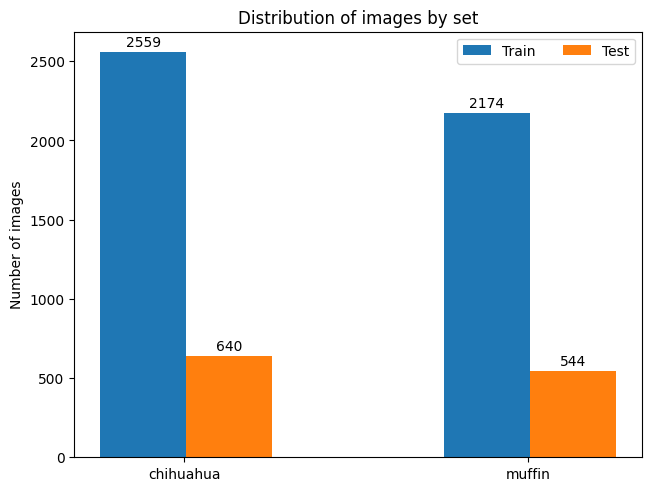

In [ ]:
labels = ("chihuahua", "muffin")
data = {
    'Train': counts_train,
    'Test': counts,
}

x = np.arange(len(labels))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_ylabel('Number of images')
ax.set_title('Distribution of images by set')
ax.set_xticks(x + 0.12, labels)
ax.legend(loc='upper right', ncols=2)

plt.show()

Based on the graph, it's evident that there are two main classes: "Chihuahua" and "Muffin". We've opted for binary encoding, assigning "1" to the Chihuahua class and "0" to the Muffin class.

Additionally, we observed that the representation of these classes within the two directories is balanced.

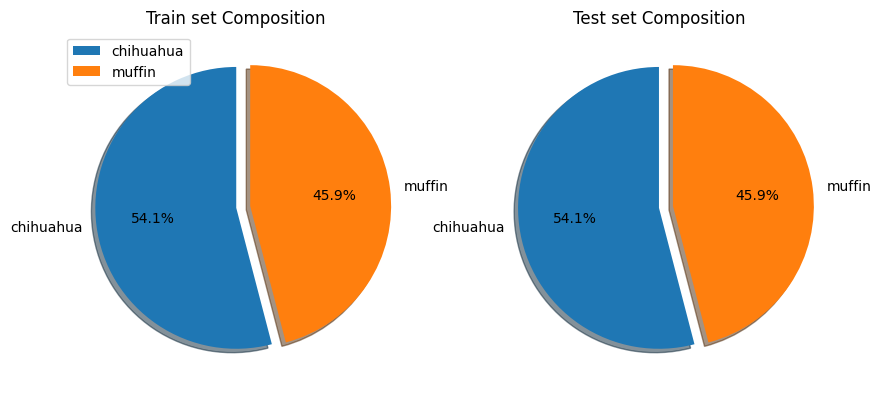

In [ ]:
labels = "chihuahua", "muffin"
explode = (0, 0.1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

ax1.pie(counts_train, labels = labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Train set Composition')
ax1.legend(labels, loc = "best")

ax2.pie(counts,labels = labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Test set Composition')

plt.show()

## Data Extraction

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE
  )

Found 4733 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE
  )

Found 1184 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

print('Number of training batches:', tf.data.experimental.cardinality(train_ds).numpy())

['chihuahua', 'muffin']
Number of training batches: 148


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_images = []
train_labels = []
for images, labels in tqdm(train_ds):
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shape of train_images and train_labels
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)


100%|██████████| 148/148 [06:24<00:00,  2.60s/it]


Shape of train_images: (4733, 128, 128, 3)
Shape of train_labels: (4733,)


### SHOW SOME IMAGES

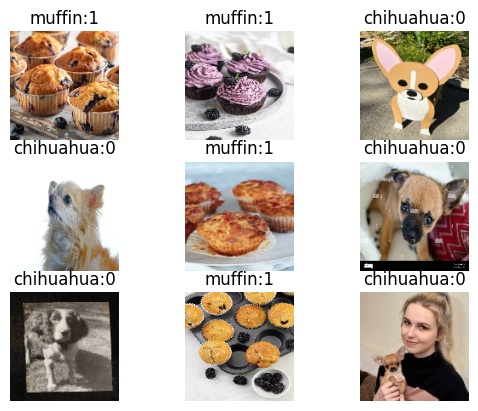

In [ ]:
plt.figure()
for images, labels in train_ds.take(1):
  for i in range(9):
     ax = plt.subplot(3, 3,  i + 1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(f"{class_names[labels[i]]}:{labels[i].numpy()}" )
     plt.axis("off")

## DATA AUGMENTATION AND SOME IMAGEs

In [ ]:
trainDataGen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range = [0.5, 1.5],
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1/255
)

testDataGen=ImageDataGenerator(
    rescale=1/255
)

### Some images

In [ ]:
class_name=['chihuahua', 'muffin']

def getSamplesFromDataGen(resultData):
    x = resultData.next() #fetch the first batch
    a = x[0] # train data
    b = x[1] # train label

    for i in range(9):
      ax = plt.subplot(3, 3,  i + 1)
      plt.imshow(a[i])
      plt.title(f"{class_name[int(b[i])]}:{int(b[i])}" )
      plt.axis("off")
    plt.show()

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array

def getOneImages(path):
  img = load_img(path)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(zoom_range=[0.5,1.0], rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range = [0.5, 1.5],
    vertical_flip=True,
    fill_mode='nearest')
  it = datagen.flow(samples, batch_size=1)
  for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')

    plt.imshow(image)
    plt.axis('off')
  plt.show()

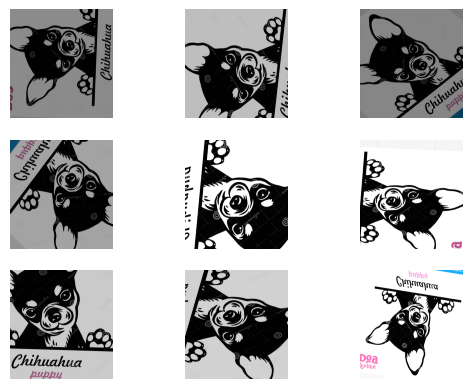

In [ ]:
getOneImages('/content/gdrive/MyDrive/Kaggle/MuffinVsCani/test/chihuahua/img_0_590.jpg')

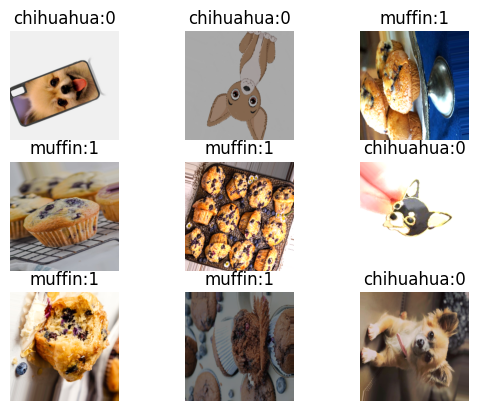

In [ ]:
#getSamplesFromDataGen(train)